In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.nn import MSELoss
from mediapipe import solutions

from utils import smooth_data, split_data
from video_converter import Video2DataFrame
from custom_pose_landmarks import CustomPoseLandmark
from model_builder import RNN
from engine import train
from data_setup import create_dataloaders

In [ ]:
# Prepare paths
data_path = '../data/'
video_path = os.path.join(data_path, 'raw/squat')

# Read personal data from excel
personal_data = pd.read_excel(os.path.join(data_path, 'PersonalData.xlsx'))

In [ ]:
# Selected values of pose landmarks corresponding to PoseLandmark class from MediaPipe library
values = [0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 24, 25, 26, 27, 28, 31, 32]

# Custom pose landmark names and their connections
landmarks = {
    'THORAX': ['NOSE'],
    'PELVIS': ['LEFT_HIP', 'RIGHT_HIP'],}

# MediaPipe solutions
mp_drawing = solutions.drawing_utils
mp_pose = solutions.pose

custom_pose = CustomPoseLandmark(mp_pose, values, landmarks)

In [ ]:
converter = Video2DataFrame(mp_pose, mp_drawing, custom_pose)

# Convert videos to dataframe
dataframe = converter.get_dataframe(
    source=video_path,
    detection=0.9,
    tracking=0.9,
    video_display=False
)

In [ ]:
# dataframe.to_csv('ConvertedSquats.csv', index=False)

In [ ]:
dataframe = pd.read_csv('ConvertedSquats.csv')

In [ ]:
# Merge personal and video data
data = pd.merge(dataframe, personal_data, on='Id')

# Calculate the maximum load that was passed
max_load = data.loc[data['Lifted'] == 1, ['Id', 'Load']].groupby(by='Id', as_index=False).max()
max_load = max_load.rename(columns={'Load': 'MaxLoad'})
data = pd.merge(data, max_load, on='Id')

# Calculate what percentage of the maximum load is the current load
data['PercentageMaxLoad'] = 100 * data['Load'] / data['MaxLoad']

del data['MaxLoad']

# Get only lifted approaches
data = data.loc[data['Lifted'] == 1]

# Variables that aren't needed in the first run
to_drop = [
    'Id', 'Age', 'Height', 'Weight', 'PastInjuries', 'LastInjury', 'PainDuringTraining', 'SquatRecord',
    'BenchPressRecord', 'DeadliftRecord', 'PhysicalActivities', 'SetNumber', 'Load', 'Lifted', 'Timestamp']

data = data.drop(columns=to_drop)

# Categorical variables that need to be one hot encoded
to_one_hot = [
    'ProficiencyLevel', 'EquipmentAvailability', 'TrainingProgram', 'TrainingFrequency', 'CameraPosition']

data = pd.get_dummies(data, columns=to_one_hot, dtype=int)

# Move the PercentageMaxLoad column to the end of the dataframe
percentage = data.pop('PercentageMaxLoad')
data['PercentageMaxLoad'] = percentage

# Smooth all features extracted from MediaPipe solution
data = smooth_data(data, frac=0.1, it=3)

In [40]:
# data.to_csv('OneRepMaxData.csv', index=False)

In [41]:
data = pd.read_csv('OneRepMaxData.csv')

In [3]:
# Get dictionary of file ids assingned to different datasets
file_ids = split_data(data)

# Setup hyperparameters
BATCH_SIZE = 128
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    data=data,
    file_ids=file_ids,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

In [4]:
import torch.nn as nn

class RMSELoss(nn.Module):
    """
    
    """
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, y_hat, y):
        loss = torch.sqrt(self.mse(y_hat, y) + self.eps)
        return loss

In [32]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup hyperparameters
INPUT_SIZE = 78
HIDDEN_SIZE = 512
NUM_LAYERS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize RNN model class instance
model = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS)

# Send model to device
model = model.to(device=DEVICE)

In [33]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = RMSELoss()

In [34]:
torch.cuda.empty_cache()

In [35]:
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train loss: 64.8210 | validation loss: 59.4053
Epoch: 2 | train loss: 58.3386 | validation loss: 52.7342
Epoch: 3 | train loss: 50.9325 | validation loss: 44.4490
Epoch: 4 | train loss: 41.8925 | validation loss: 34.9720
Epoch: 5 | train loss: 32.0149 | validation loss: 25.7678
Epoch: 6 | train loss: 23.6297 | validation loss: 21.2932
Epoch: 7 | train loss: 21.2961 | validation loss: 22.7091
Epoch: 8 | train loss: 21.6490 | validation loss: 22.4471
Epoch: 9 | train loss: 21.0962 | validation loss: 21.4389
Epoch: 10 | train loss: 20.8974 | validation loss: 21.2770
Epoch: 11 | train loss: 20.9181 | validation loss: 21.2965
Epoch: 12 | train loss: 20.8545 | validation loss: 21.3951
Epoch: 13 | train loss: 20.8205 | validation loss: 21.4494
Epoch: 14 | train loss: 20.8735 | validation loss: 21.4175
Epoch: 15 | train loss: 20.8561 | validation loss: 21.3603
Epoch: 16 | train loss: 20.8255 | validation loss: 21.3538
Epoch: 17 | train loss: 20.8534 | validation loss: 21.3450
Epoch:

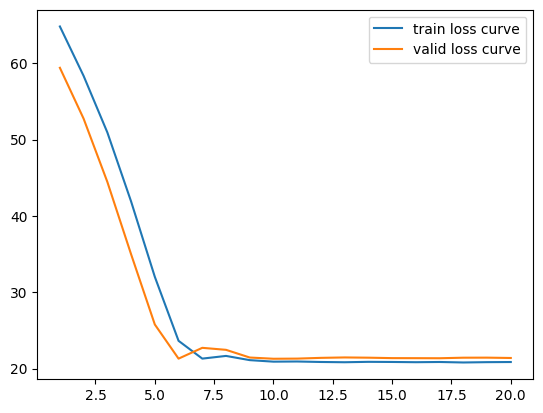

In [36]:
plt.plot(range(1, NUM_EPOCHS + 1), results['train_loss']);
plt.plot(range(1, NUM_EPOCHS + 1), results['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])

In [37]:
# Put model in evaluation mode
model.eval()

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for data, targets in train_dataloader:
        # Send data to target device
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        predictions = model(data)

        # Calculate and accumulate loss
        loss = loss_fn(targets, predictions)

In [38]:
pd.DataFrame({'targets': targets.cpu().squeeze(), 'predictions': predictions.cpu().squeeze()}, index=range(len(targets.cpu())))

,targets,predictions
0,63.043480,63.368301
1,81.250000,63.368301
2,22.222221,63.368301
3,14.285714,63.368301
4,40.625000,63.368301
...,...,...
103,68.181816,63.368301
104,54.838711,63.368301
105,70.588234,63.368301
106,75.000000,63.368301
